# Loan eligibility

In [4]:
! pip install lazypredict

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: ! pip install
          ^


In [ ]:
#Requierd ibaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector

## Data Visualization

In [ ]:
#Loading csv data dropping Loan_ID because not usefull
path = "/data.csv"

#dropping Loan_ID because it is not an important feature
loan_df = pd.read_csv(path).drop(["Loan_ID"],axis=1)

In [ ]:
#Diplaying Head of Data
loan_df.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.00,0.00,NaN,360.00,1.00,Urban,Y
1,Male,Yes,1,Graduate,No,NaN,1508.00,128.00,360.00,1.00,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.00,0.00,66.00,360.00,1.00,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120.00,360.00,1.00,Urban,Y
4,Male,No,0,Graduate,No,6000.00,0.00,141.00,360.00,1.00,Urban,Y
5,NaN,Yes,2,Graduate,Yes,5417.00,4196.00,267.00,360.00,1.00,Urban,Y
6,Male,Yes,0,Not Graduate,No,2333.00,1516.00,95.00,360.00,1.00,Urban,Y
7,Male,Yes,3+,Graduate,No,3036.00,2504.00,158.00,360.00,0.00,Semiurban,N
8,Male,Yes,2,NaN,No,4006.00,1526.00,168.00,360.00,1.00,Urban,Y
9,Male,Yes,1,Graduate,No,12841.00,10968.00,349.00,360.00,1.00,Semiurban,N


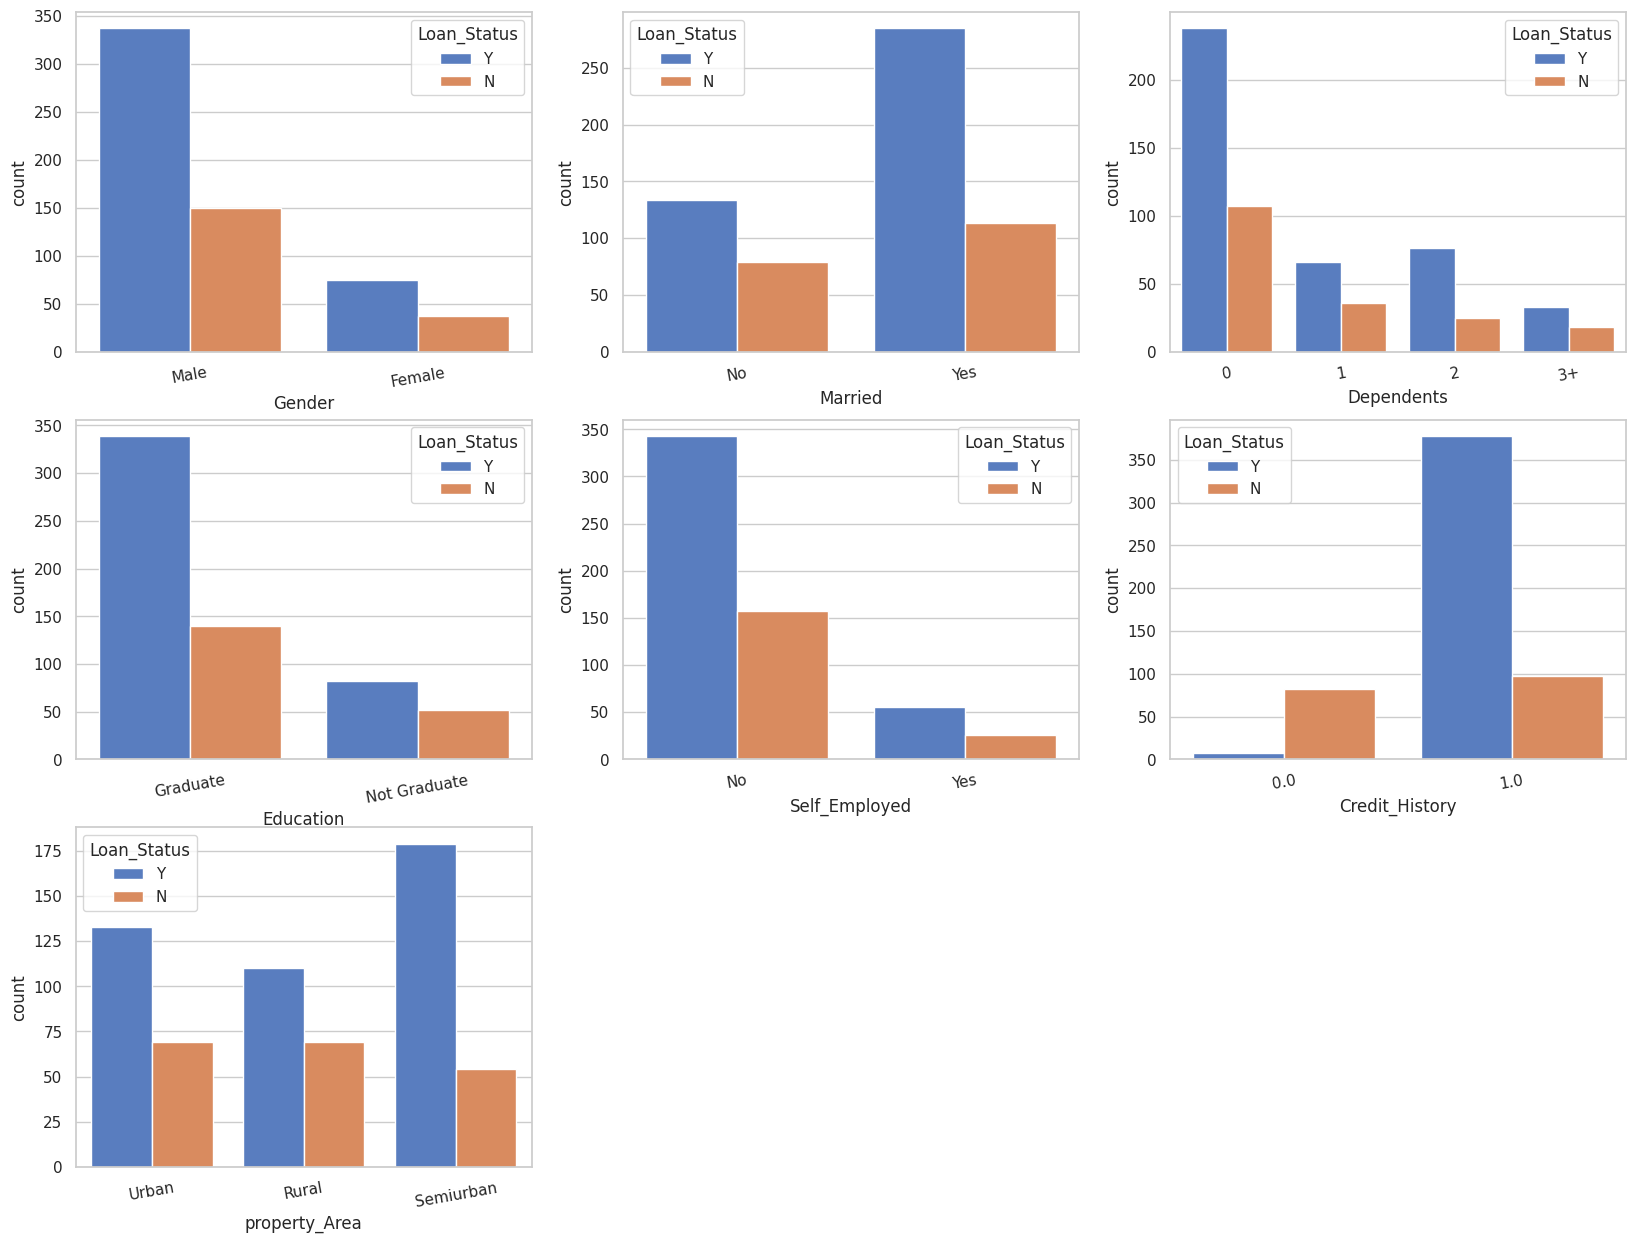

In [ ]:
#Ploting loan frequency for diffrent classes
loan_class_list = ['Gender','Married', 'Dependents', 
                     'Education','Self_Employed','Credit_History','property_Area'] 

plt.figure(figsize = (20, 15))
sns.set_theme(style="whitegrid", palette="muted")

for i in enumerate(loan_class_list):
        plt.subplot(3, 3,i[0]+1)
        sns.countplot(data =loan_df, x = i[1], hue = "Loan_Status")
        plt.xticks(rotation = 10)

<font size =4> Observations:<br>
- Significantly more people that have a credit history received a loan, we also see a higher acceptance rate for people that have a Graduate education level


Text(0.5, 1.0, 'Count Loan vs No Loan')

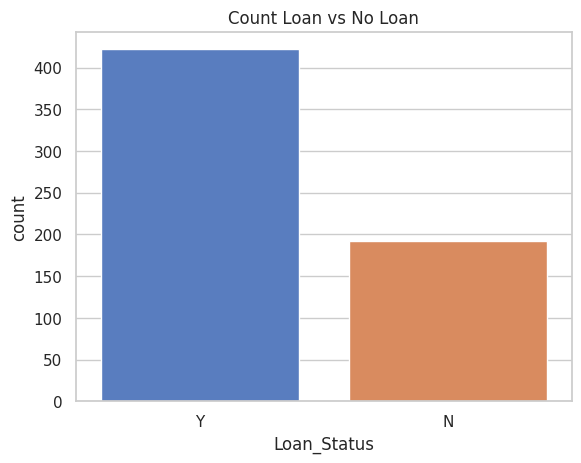

In [ ]:
#count plot to check if dataset is balanced
countplot = sns.countplot(data = loan_df, x = "Loan_Status") 
countplot.set_title("Count Loan vs No Loan")

- <font size = 4> Observations: The dataset is mildly imbalanced, having more more positive loan status

Text(0.5, 1.0, ' Loan Data Correlation')

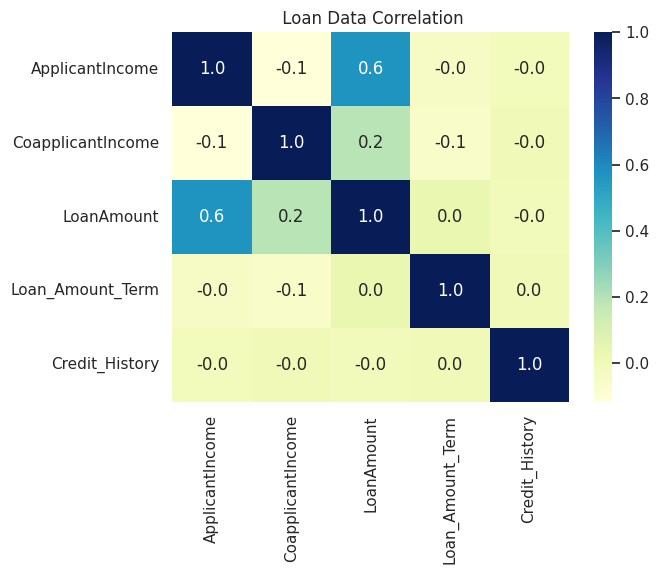

In [ ]:
#Generating a heat map to uderstand the correlation among variables
sns.heatmap(data = loan_df.corr(), annot=True,fmt=".1f", vmax = 1, cmap="YlGnBu" ).set_title(" Loan Data Correlation")

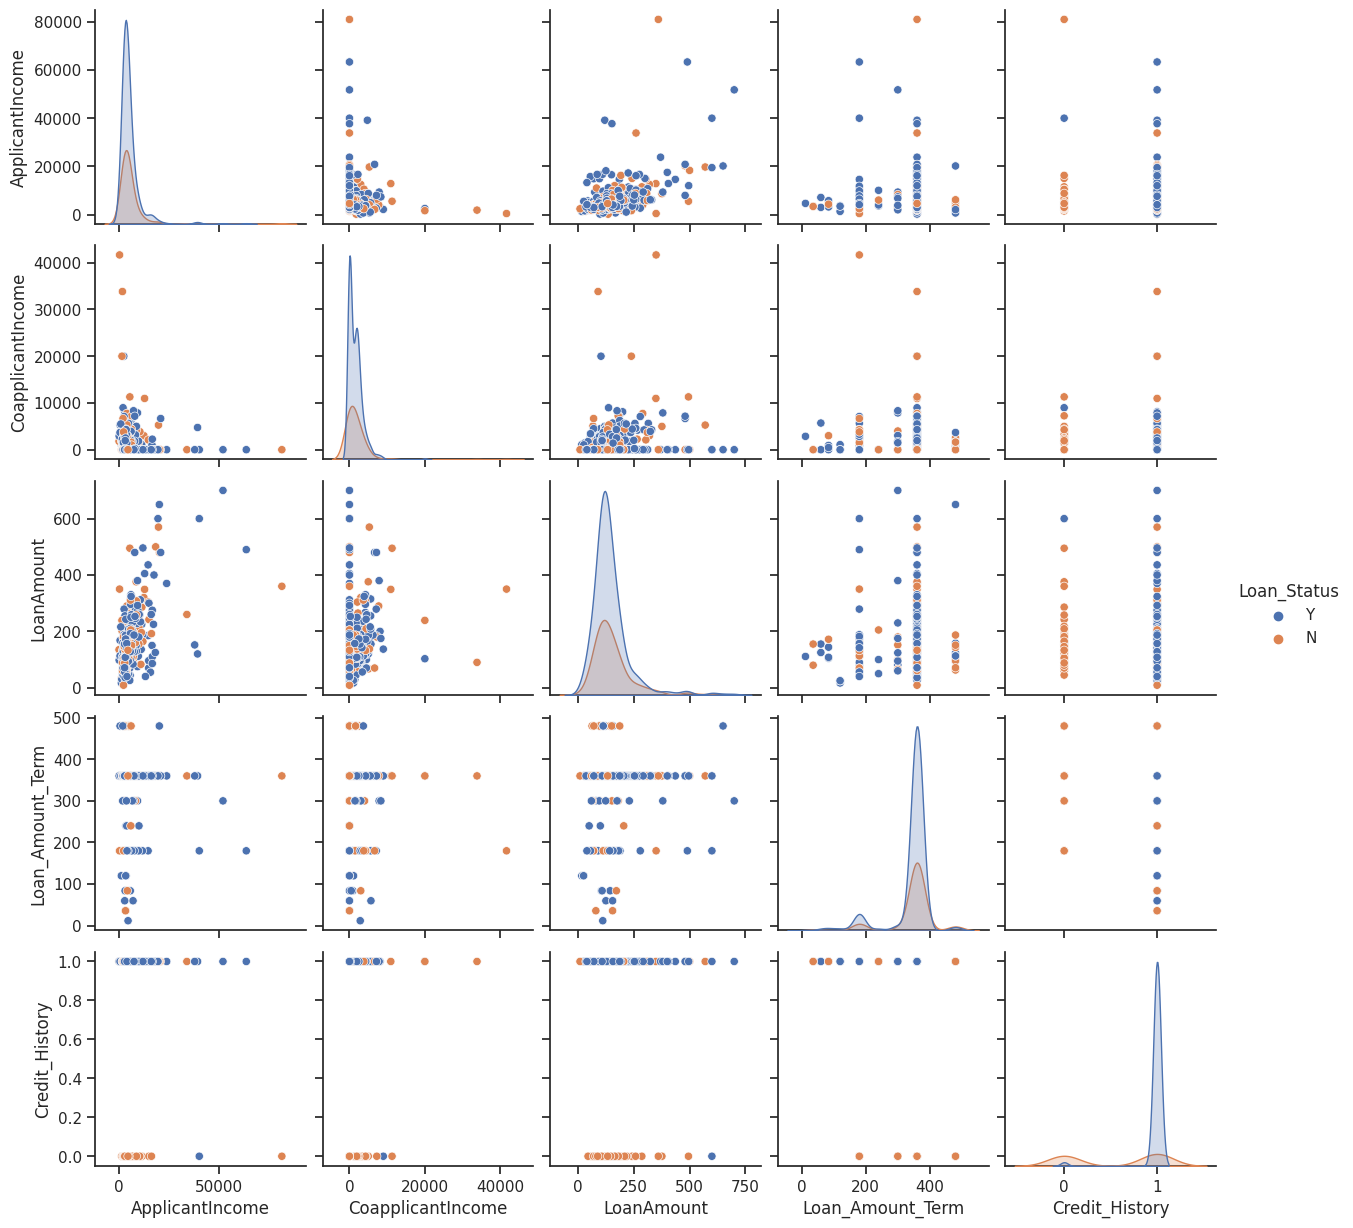

In [ ]:
#Pairplot to check correlation between variables 
sns.set_theme(style="ticks")
sns.pairplot(loan_df, hue="Loan_Status")

- <font size = 4> Observations: There are no variables that are highly correlated

In [ ]:
#Mean, Median, Quantiles, and range for all features
loan_df_describe = loan_df.describe() 
loan_df_describe.loc["Range"] = loan_df_describe.loc["max"]-loan_df_describe.loc["min"]
loan_df_describe

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,612.00,613.00,592.00,600.00,564.00
mean,5405.54,1620.89,146.41,342.00,0.84
std,6118.91,2928.62,85.59,65.12,0.36
min,150.00,0.00,9.00,12.00,0.00
25%,2875.75,0.00,100.00,360.00,1.00
50%,3806.00,1167.00,128.00,360.00,1.00
75%,5803.75,2302.00,168.00,360.00,1.00
max,81000.00,41667.00,700.00,480.00,1.00
Range,80850.00,41667.00,691.00,468.00,1.00


<font size =4> Checking and removing outliers

(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'ApplicantIncome'),
  Text(2, 0, 'CoapplicantIncome'),
  Text(3, 0, 'LoanAmount'),
  Text(4, 0, 'Loan_Amount_Term'),
  Text(5, 0, 'Credit_History')])

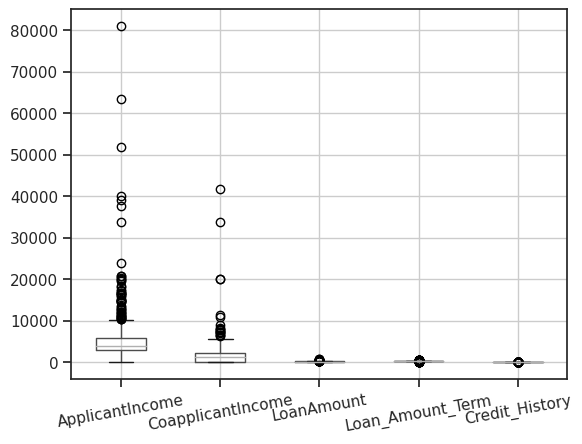

In [ ]:
#Ploting to check for outliers
loan_df.boxplot()
plt.xticks(rotation = 10)

Observations: We can see that ApplicationIncome and CoapplicationIncome have ourliers

In [ ]:
#Function to check for outliers, and return a list of idecies
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3-Q1
    lowerBound = Q1 -1.5*IQR
    upperBound = Q3 +1.5*IQR
    index_list = df.index[(df[ft] < lowerBound) | (df[ft] > upperBound)]
    return index_list

In [ ]:
#Storing indecies of outliers
index_list = []
for ft in ["ApplicantIncome","CoapplicantIncome"]:
    index_list.extend(outliers(loan_df, ft))

In [ ]:
#Function to remove outliers given index of outlier
def removeOutliers(df, index_list): 
    #Sorting indeces and making them unique
    index_list = sorted(set(index_list))
    df = df.drop(index_list)
    return df

In [ ]:
#Removing outliers for ApplicantIncome,CoapplicantIncome and creating a new df
loan_df = removeOutliers(loan_df, index_list)
loan_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.00,0.00,NaN,360.00,1.00,Urban,Y
1,Male,Yes,1,Graduate,No,NaN,1508.00,128.00,360.00,1.00,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.00,0.00,66.00,360.00,1.00,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.00,2358.00,120.00,360.00,1.00,Urban,Y
4,Male,No,0,Graduate,No,6000.00,0.00,141.00,360.00,1.00,Urban,Y


In [ ]:
#Shape of data
loan_df.shape

(548, 12)

In [ ]:
#Checking for null values
loan_df.isnull().sum()

Gender               12
Married               3
Dependents           14
Education             1
Self_Employed        29
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           20
Loan_Amount_Term     14
Credit_History       45
property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
#Checking featute information of dataset
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             536 non-null    object 
 1   Married            545 non-null    object 
 2   Dependents         534 non-null    object 
 3   Education          547 non-null    object 
 4   Self_Employed      519 non-null    object 
 5   ApplicantIncome    546 non-null    float64
 6   CoapplicantIncome  547 non-null    float64
 7   LoanAmount         528 non-null    float64
 8   Loan_Amount_Term   534 non-null    float64
 9   Credit_History     503 non-null    float64
 10  property_Area      548 non-null    object 
 11  Loan_Status        548 non-null    object 
dtypes: float64(5), object(7)
memory usage: 55.7+ KB


- <font size = 4> Observations: The data set has missing values for multiple diffrent features, and for bothe categorical and numerical features

## Data Encoding

In [ ]:
#Encoding all object data, in the data frame
obj_columns = ['Gender','Married', 'Dependents','Education','Self_Employed', 'property_Area','Loan_Status']
encoded_loan_df = pd.get_dummies(loan_df[obj_columns], obj_columns,drop_first=True)
encoded_loan_df.head()

,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,property_Area_Semiurban,property_Area_Urban,Loan_Status_Y
0,1,0,0,0,0,0,0,0,1,1
1,1,1,1,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,1,1
3,1,1,0,0,0,1,0,0,1,1
4,1,0,0,0,0,0,0,0,1,1


In [ ]:
#Dropping Gender, Married, Education,Self_Employed, property_Area,Loan_Status features and replacing with encoded data
loan_df = loan_df.drop(obj_columns, axis =1)
loan_df = pd.concat([loan_df,encoded_loan_df],axis =1)

In [ ]:
#Displaying head of encoded dataframe
loan_df.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,property_Area_Semiurban,property_Area_Urban,Loan_Status_Y
0,5849.00,0.00,NaN,360.00,1.00,1,0,0,0,0,0,0,0,1,1
1,NaN,1508.00,128.00,360.00,1.00,1,1,1,0,0,0,0,0,0,0
2,3000.00,0.00,66.00,360.00,1.00,1,1,0,0,0,0,1,0,1,1
3,2583.00,2358.00,120.00,360.00,1.00,1,1,0,0,0,1,0,0,1,1
4,6000.00,0.00,141.00,360.00,1.00,1,0,0,0,0,0,0,0,1,1


## KNN Imuptation

In [ ]:
#Normalizing data before using KNN imputer
scaler = MinMaxScaler()
loan_df = pd.DataFrame(scaler.fit_transform(loan_df), columns = loan_df.columns)

In [ ]:
#Displaying head of encoded dataframe after normalization
loan_df.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,property_Area_Semiurban,property_Area_Urban,Loan_Status_Y
0,0.57,0.00,NaN,0.74,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
1,NaN,0.26,0.32,0.74,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.29,0.00,0.16,0.74,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00
3,0.24,0.41,0.30,0.74,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
4,0.59,0.00,0.36,0.74,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00


In [ ]:
#Data was succesfully imputed
loan_df.isnull().sum()

ApplicantIncome             2
CoapplicantIncome           1
LoanAmount                 20
Loan_Amount_Term           14
Credit_History             45
Gender_Male                 0
Married_Yes                 0
Dependents_1                0
Dependents_2                0
Dependents_3+               0
Education_Not Graduate      0
Self_Employed_Yes           0
property_Area_Semiurban     0
property_Area_Urban         0
Loan_Status_Y               0
dtype: int64

In [ ]:
#imputing dataset 
imputer = KNNImputer(n_neighbors=2)
loan_df = pd.DataFrame(imputer.fit_transform(loan_df),columns = loan_df.columns)

In [ ]:
#Data was succesfully imputed
loan_df.isnull().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
property_Area_Semiurban    0
property_Area_Urban        0
Loan_Status_Y              0
dtype: int64

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          548 non-null    float64
 1   CoapplicantIncome        548 non-null    float64
 2   LoanAmount               548 non-null    float64
 3   Loan_Amount_Term         548 non-null    float64
 4   Credit_History           548 non-null    float64
 5   Gender_Male              548 non-null    float64
 6   Married_Yes              548 non-null    float64
 7   Dependents_1             548 non-null    float64
 8   Dependents_2             548 non-null    float64
 9   Dependents_3+            548 non-null    float64
 10  Education_Not Graduate   548 non-null    float64
 11  Self_Employed_Yes        548 non-null    float64
 12  property_Area_Semiurban  548 non-null    float64
 13  property_Area_Urban      548 non-null    float64
 14  Loan_Status_Y            5

## Feature Engineering with Stepwise Sequential Feature Selector

In [ ]:
#Storing Target and input Variables
target = loan_df.Loan_Status_Y #Y
input = loan_df.drop(["Loan_Status_Y"], axis = 'columns') #X

In [ ]:
#Testing significant features 
lr_clf = LogisticRegression ()
sfs = SequentialFeatureSelector(lr_clf) 
sfs.fit(input,target)

SequentialFeatureSelector(estimator=LogisticRegression())

In [ ]:
sfs.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False])

In [ ]:
input.head(1)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,property_Area_Semiurban,property_Area_Urban
0,0.57,0.00,0.34,0.74,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


- <font size = 4> Selected features of Stepwise Sequential Feature Selector are: <br>
"ApplicantIncome",	"CoapplicantIncome"	,"LoanAmount",	"Loan_Amount_Term", "Credit_History",	"Gender_Male",	"Married_Yes"	

In [ ]:
#Storing names of selected features from stepwise Sequential Feature Selecto
selected_features = ["ApplicantIncome", "CoapplicantIncome" ,"LoanAmount", "Loan_Amount_Term", "Credit_History", "Gender_Male", "Married_Yes"]

In [ ]:
input = loan_df[selected_features]

In [ ]:
#spliting Data Set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(input, target,test_size=0.2, random_state=42)

## Models 

In [ ]:
#Fitting a Linear Regression Model
lr_clf = LogisticRegression ()
lr_clf.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
#Checking Accuracy of our model
lr_Y_pred = lr_clf.predict(X_test)
print("Accuraccy:", accuracy_score(Y_test, lr_Y_pred)*100)


Accuraccy: 84.54545454545455


In [ ]:
#Using Lazy predic to compare multiple classifiers
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)
models

100%|██████████| 29/29 [00:01<00:00, 28.32it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.86,0.79,0.79,0.85,0.17
LabelSpreading,0.84,0.79,0.79,0.83,0.02
BaggingClassifier,0.85,0.79,0.79,0.84,0.04
LabelPropagation,0.83,0.78,0.78,0.82,0.02
ExtraTreesClassifier,0.85,0.78,0.78,0.84,0.14
RidgeClassifier,0.85,0.76,0.76,0.83,0.01
NearestCentroid,0.85,0.76,0.76,0.83,0.01
LogisticRegression,0.85,0.76,0.76,0.83,0.02
LinearDiscriminantAnalysis,0.85,0.76,0.76,0.83,0.02


## Model evaluation

In [ ]:
#Function for ploting confusion matrix
def confusion_matrix_plot(clf_model,X_test, Y_test, title):
    predictions = clf_model.predict(X_test)
    cm = confusion_matrix(Y_test, predictions, labels=clf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_model.classes_)
    disp.plot()
    plt.title(title)
    plt.show()

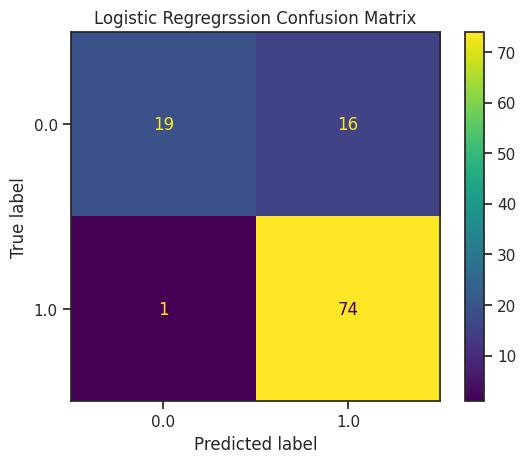

In [ ]:
# Ploting Confusion Matrix for Logistic Regression Classifier
lr_title = "Logistic Regregrssion Confusion Matrix"
confusion_matrix_plot(lr_clf,X_test, Y_test,lr_title)

In [ ]:
#Displaying The Classification report for Logistic regression to find the F-score and Accuracy 
print(classification_report(Y_test, lr_Y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.54      0.69        35
         1.0       0.82      0.99      0.90        75

    accuracy                           0.85       110
   macro avg       0.89      0.76      0.79       110
weighted avg       0.86      0.85      0.83       110



<font size = 4> Ploting AUC-ROC Curve

In [5]:
#Prediction Probabilities
r_probs = [0 for _ in range(len(Y_test))]
lr_probs = lr_clf.predict_proba(X_test)
lr_probs

ERROR: Error in parse(text = x, srcfile = src): <text>:2:11: unexpected '['
1: #Prediction Probabilities
2: r_probs = [
             ^


In [ ]:
#Storing Probabilities for the positive outcome
lr_probs = lr_probs[:,1]

In [ ]:
# Calculating ROC-AUC Score
r_auc = roc_auc_score(Y_test, r_probs)
lr_auc = roc_auc_score(Y_test,lr_probs)

In [ ]:
#Printing ROC-AUC Scores
print("Roc-AUC score Random Prediction: ",r_auc)
print("Roc-AUC score Logistic Regression: ",lr_auc )

Roc-AUC score Random Prediction:  0.5
Roc-AUC score Logistic Regression:  0.8335238095238096


In [ ]:
# Calculating ROC-AUC Curve
r_fpr, r_tpr, _ = roc_curve(Y_test, r_probs)
lr_fpr, lr_tpr,_ = roc_curve(Y_test,lr_probs)

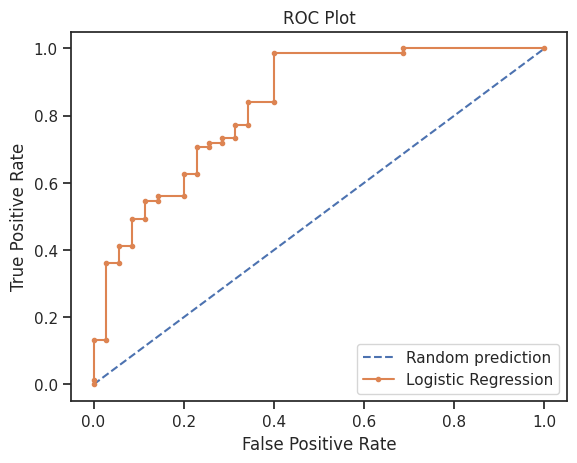

In [ ]:
#Plot AUC-ROC  Curve
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction' )
plt.plot(lr_fpr, lr_tpr,marker='.', label='Logistic Regression')
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()